### Only use the third batch from the paper, will ignore rest period during the cycling process for now.
### 

In [1]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import itertools

import dionysus as ds

In [3]:
cycles = f[bat['cycles'][4,0]]
cycles.keys()

for i in range(num_cells):
# for i in range(3,5 ): # for testing 
    cycles = f[bat['cycles'][i,0]]
    cycle_dict = {}
    cycle_dict_pd = {}
    cycle_dict_pdstd = {}
    
#     for j in range(cycles['I'].shape[0]):
    for j in [2, 100]:
        I = np.hstack((f[cycles['I'][j,0]][()]))
        I_sdd = (I-np.mean(I)) / np.std(I)

        Qc = np.hstack((f[cycles['Qc'][j,0]][()]))
        Qc_sdd = (Qc-np.mean(Qc)) / np.std(Qc)

        Qd = np.hstack((f[cycles['Qd'][j,0]][()]))
        Qd_sdd = (Qd-np.mean(Qd)) / np.std(Qd)

        Qdlin = np.hstack((f[cycles['Qdlin'][j,0]][()]))

        T = np.hstack((f[cycles['T'][j,0]][()]))
        T_sdd = (T-np.mean(T)) / np.std(T)

        Tdlin = np.hstack((f[cycles['Tdlin'][j,0]][()]))

        V = np.hstack((f[cycles['V'][j,0]][()]))
        V_sdd = (V-np.mean(V)) / np.std(V)

        dQdV = np.hstack((f[cycles['discharge_dQdV'][j,0]][()]))

        t = np.hstack((f[cycles['t'][j,0]][()]))

        cd = {'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin, 'T': T, 'Tdlin': Tdlin, 'V':V, 'dQdV': dQdV, 't':t}
        cycle_dict[str(j)] = cd
        cycle_dict_pd[str(j)] = pd.DataFrame(data=np.array([I, V, Qc, Qd, T]).T, 
                                             index=t,
                                             columns=['I', 'V', 'Qc', 'Qd', 'T'])
        cycle_dict_pdstd[str(j)] = pd.DataFrame(data=np.array([I_sdd, V_sdd, Qc_sdd, Qd_sdd, T_sdd]).T, 
                                             index=t,
                                             columns=['I', 'V', 'Qc', 'Qd', 'T'])
        
    ###########################
    ###########################
#     for j in [2, 100]:
        rad_df = np.random.normal(0, .000001, np.shape(cycle_dict_pd[str(j)]))
        nsy_df = cycle_dict_pdstd[str(j)].add(rad_df)
        rll_corr = nsy_df.rolling(50).corr()
        itr_num = int(rll_corr.dropna().shape[0]/5)
        cls_lbl_all = pd.DataFrame(columns=['I', 'V', 'Qc', 'Qd', 'T'])
        clustering = DBSCAN(eps=.3, min_samples=0, metric='precomputed')
        tt = rll_corr.dropna()
        for ii in range(itr_num):
            clustering.fit(1-tt.iloc[ii*5:ii*5+5])
            cls_lbl_all.loc[tt.iloc[ii*5:ii*5+5].index.tolist()[0][0]] = clustering.labels_
#         with open(f'./pickled/bat3cs1/trial1/cell{i}_cyc{j}.pkl', mode='wb') as fp:
#             pickle.dump(cls_lbl_all, file=fp)

In [51]:
# with open('./pickled/bat3cs1/trial1/test1.pkl', mode='wb') as fp:
#     pickle.dump(cls_lbl_all, file=fp)

In [60]:
# with open('./pickled/bat3cs1/trial1/test1.pkl', mode='rb') as fp :
#     cyc2 = pickle.load(fp)


In [4]:
for i in range(num_cells):
# for i in range(3,5 ): # for testing 
    for j in [2, 100]:
#         cycles = f[bat['cycles'][i,0]]
#         t = np.hstack((f[cycles['t'][j,0]][()]))
        cls_lbl2 = []
        with open(f'./pickled/bat3cs1/trial1/cell{i}_cyc{j}.pkl', mode='rb') as fp :
            cyc_tmp = pickle.load(fp)
        for cbs in list(itertools.combinations(cyc_tmp.columns.tolist(), 2)):
        #     print(cbs)
            cls_lbl2.append(cbs[0]+'_'+cbs[1])
        
        dyn_grh = pd.DataFrame(columns=cls_lbl2)
        
        for idx, row in cyc_tmp.iterrows():
            # get the number of clusters
            num_cls = row.values.max()

            # iter. through all clusters, the cluster output of sklearn is from 0 to N.
            for clslb in range(num_cls+1):
        #         print(get_indexes(clslb, row.tolist()))
                # for every cluster, retrieve the indices of the members
                clstmp = get_indexes(clslb, row.tolist())
                # sort to make sure
                clstmp.sort()
                # Regardless of how many memebers in a cluster, will present in pairs, thus will be 1-simplices.
                # In this particular case, there is no need to do
                if len(clstmp) >=3:
                    # if there are more than 3 (include 3) elements in 
                    # current cluster, fix the first one and iterate through the rest to pair.
                    for iii in range(1,len(clstmp)):
                        clstmp_bin = [clstmp[0], clstmp[iii]]
                        dyn_grh.loc[idx, col_names[clstmp[0]] +'_'+ col_names[clstmp[1]]] = True
        #             print(col_names[clstmp[0]] +'_'+ col_names[clstmp[1]])
                if len(clstmp) == 2:
                    # if there are only two cls
                    clstmp_bin = clstmp
                    dyn_grh.loc[idx, col_names[clstmp[0]] +'_'+ col_names[clstmp[1]]] = True
        #             print(col_names[clstmp[0]] +'_'+ col_names[clstmp[1]])
        
        dyn_grh.fillna(False, inplace=True)
        cls_1simp = {}
        for idx, row in dyn_grh.T.iterrows():
            cls_1simp[idx] = \
            get_indexes(True, [ xx!=yy for xx, yy in zip(row.tolist()+[False], [False]+row.tolist())])
        
        
        simplices = [[xx] for xx in list(range(len(main_col_list)))]+\
        [list(xx) for xx in itertools.combinations(range(len(main_col_list)), 2)]
        time_points = dyn_grh.index.values
        time_points = np.append(time_points, time_points[-1])
        # print(simplices)
        # simp_times = [[0, len(dyn_grh)] for ii in range(len(main_col_list))]
#         simp_times = [[dyn_grh.index.values[0], len(dyn_grh)-1] for ii in range(len(main_col_list))]
        simp_times = [[time_points[0], time_points[-1]] for ii in range(len(main_col_list))]

        # simp_times = [[0, len(dyn_grh)] for ii in range(len(main_col_list)-1)]
        # simp_times.append([0])

        # simp_times = [[0 ] for ii in range(len(main_col_list))]

        for cmb in [list(xx) for xx in itertools.combinations(range(len(main_col_list)), 2)]:
        #     print(main_col_list[cmb[0]]+'_'+main_col_list[cmb[1]])
#             simp_times.append(cls_1simp[main_col_list[cmb[0]]+'_'+main_col_list[cmb[1]]])
            simp_tm_id = cls_1simp[main_col_list[cmb[0]]+'_'+main_col_list[cmb[1]]]
            simp_times.append([time_points[iii] for iii in simp_tm_id])
            
        fz = ds.Filtration(simplices)
        times = simp_times
        zz1, dgms1, cells1 = ds.zigzag_homology_persistence(fz, times)
        with open(f'./pickled/bat3cs1/trial1/barcodes/bcd_cell{i}_cyc{j}.pkl', mode='wb') as fp:
            pickle.dump(dgms1, file=fp)

[]

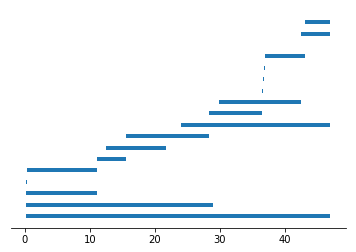

In [5]:
bars1 = pd.DataFrame(columns=['birth', 'death'])
iii = 0
for bar in dgms1[0]:
#     print(bar)
#     bars1.loc[iii,:] = [dyn_grh.index.values[int(bar.birth)], dyn_grh.index.values[int(bar.death)-1]]
    bars1.loc[iii,:] = [bar.birth, bar.death]
    iii +=1
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

yloc = 0.
for idx, row in bars1.sort_values(by=['birth', 'death'], ascending=[True, False]).iterrows():
    ax3.broken_barh(xranges=[(row['birth'], (row['death']-row['birth']))], yrange=(yloc, 7))
#     print(row['death'])
    yloc += 20
#     print(row)
# ax3.set_ylim(0, 100)
ax3.set_yticks([])
ax3.set_yticklabels('')

In [38]:
cyc_selector = [2,100]
cyc_dis_2_100 = []
cyc_lf = []
for i in range(num_cells):
# for i in range(3,5 ): # for testing 
#     for j in [2, 100]:
        cls_lbl2 = []
        jj1 = cyc_selector[0]
        jj2 = cyc_selector[1]
        with open(f'./pickled/bat3cs1/trial1/barcodes/bcd_cell{i}_cyc{jj1}.pkl', mode='rb') as fp:
            dgm1 = pickle.load(fp)
        with open(f'./pickled/bat3cs1/trial1/barcodes/bcd_cell{i}_cyc{jj2}.pkl', mode='rb') as fp:
            dgm2 = pickle.load(fp)
        
#         cyc_dis_2_100.append(ds.wasserstein_distance(dgm1[0], dgm2[0]))
        cyc_dis_2_100.append(ds.bottleneck_distance(dgm1[0], dgm2[0],))
        cyc_lf.append(f[bat['cycle_life'][i,0]][()][0][0])

In [8]:
# ds.wasserstein_distance()
with open(f'./pickled/bat3cs1/trial1/barcodes/bcd_cell20_cyc2.pkl', mode='rb') as fp:
    dgm1 = pickle.load(fp)
with open(f'./pickled/bat3cs1/trial1/barcodes/bcd_cell20_cyc100.pkl', mode='rb') as fp:
    dgm2 = pickle.load(fp)

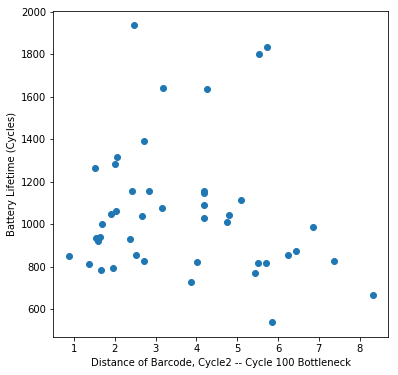

In [42]:
# plt.scatter(cyc_dis_2_100, cyc_lf)
np.corrcoef([cyc_dis_2_100, cyc_lf])
fig2 = plt.figure(figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.scatter(cyc_dis_2_100, cyc_lf)
ax2.set_xlabel('Distance of Barcode, Cycle2 -- Cycle 100 Bottleneck')
ax2.set_ylabel('Battery Lifetime (Cycles)')
fig2.savefig('Batch3_case1')

In [7]:
cycle_dict = {}
cycle_dict_pd = {}
cycle_dict_pdstd = {}
for j in range(cycles['I'].shape[0]):
    I = np.hstack((f[cycles['I'][j,0]].value))
    I_sdd = (I-np.mean(I)) / np.std(I)
    
    Qc = np.hstack((f[cycles['Qc'][j,0]].value))
    Qc_sdd = (Qc-np.mean(Qc)) / np.std(Qc)
    
    Qd = np.hstack((f[cycles['Qd'][j,0]].value))
    Qd_sdd = (Qd-np.mean(Qd)) / np.std(Qd)
    
    Qdlin = np.hstack((f[cycles['Qdlin'][j,0]].value))
    
    T = np.hstack((f[cycles['T'][j,0]].value))
    T_sdd = (T-np.mean(T)) / np.std(T)
    
    Tdlin = np.hstack((f[cycles['Tdlin'][j,0]].value))
    
    V = np.hstack((f[cycles['V'][j,0]].value))
    V_sdd = (V-np.mean(V)) / np.std(V)
    
    dQdV = np.hstack((f[cycles['discharge_dQdV'][j,0]].value))
    
    t = np.hstack((f[cycles['t'][j,0]].value))
    
    cd = {'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin, 'T': T, 'Tdlin': Tdlin, 'V':V, 'dQdV': dQdV, 't':t}
    cycle_dict[str(j)] = cd
    cycle_dict_pd[str(j)] = pd.DataFrame(data=np.array([I, V, Qc, Qd, T]).T, 
                                         index=t,
                                         columns=['I', 'V', 'Qc', 'Qd', 'T'])
    cycle_dict_pdstd[str(j)] = pd.DataFrame(data=np.array([I_sdd, V_sdd, Qc_sdd, Qd_sdd, T_sdd]).T, 
                                         index=t,
                                         columns=['I', 'V', 'Qc', 'Qd', 'T'])

/Users/tianmuzhang/miniconda/envs/scitfcpy36_dy/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


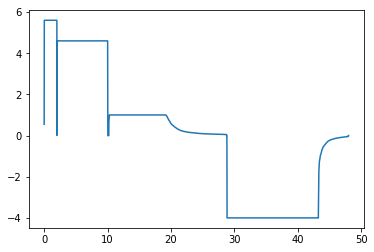

In [12]:
plt.plot(cycle_dict['2']['t'], cycle_dict['2']['I'])